In [ ]:
import os
import numpy as np
import math
import itertools
import scipy
import sys
import time
import datetime

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output

import glob
import random
from torch.utils.data import Dataset
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# HYPERPARAMETERS 
class Hyperparameters(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

hp = Hyperparameters(
    epoch=0,
    n_epochs=100,    
    dataset_train_mode="train",
    dataset_test_mode="test", 
    batch_size=4,        
    lr=.0002,
    decay_start_epoch=80,
    b1=.5,
    b2=0.999,
    n_cpu=8,
    img_size=128,
    channels=3,
    n_critic=5,
    sample_interval=100,
    num_residual_blocks=19,
    lambda_cyc=10.0,
    lambda_id=5.0)

data_path = '/content/drive/MyDrive/Datasets/Urban'


In [ ]:
def convert_to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned        

        self.files_A = sorted(glob.glob(os.path.join(root, "%sA" % mode) + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, "%sB" % mode) + "/*.*"))
        # print("self.files_B ", self.files_B)

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])


        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = convert_to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = convert_to_rgb(image_B)


        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
       
        # Finally ruturn a dict
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [ ]:
print(2 % 5)
print(2 % 8)
print(2 % 15000)

2
2
2


In [ ]:
# Methods for Image Visualization

def show_img(img,size=10):
  img = img / 2 + 0.5     
  npimg = img.numpy()
  plt.figure(figsize=(size, size))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def to_img(x):    
    x = x.view(x.size(0)*2, hp.channels, hp.img_size, hp.img_size)
    return x

import matplotlib.image as mpimg

def plot_output(path, x, y):
    img = mpimg.imread(path)
    plt.figure(figsize=(x,y))
    plt.imshow(img, cmap='gray')  
    plt.show()

**Get Train and Validation Dataloader**

In [ ]:
transforms_ = [
    transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

train_dataloader = DataLoader(
    ImageDataset(data_path, mode=hp.dataset_train_mode, transforms_=transforms_),
    batch_size=hp.batch_size,
    shuffle=True,
    num_workers=1,
)
val_dataloader = DataLoader(
    ImageDataset(data_path, mode=hp.dataset_test_mode, transforms_=transforms_),
    batch_size=4,
    shuffle=True,
    num_workers=1,
)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


**Visualize some sample images**

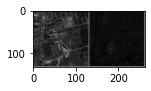

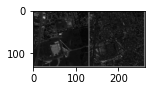

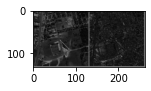

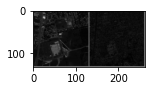

In [ ]:
pic_size = 2 

dataiter = iter(train_dataloader)
images = dataiter.next()

for i in range(len(images["A"])):
  show_img(make_grid([images["A"][i],images["B"][i]]), size=pic_size)

In [ ]:
# ReplayBuffer
class ReplayBuffer:
    # We keep an image buffer that stores
    # the 50 previously created images.
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                # Returns newly added image with a probability of 0.5.
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[
                        i
                    ] = element  # replaces the older image with the newly generated image.
                else:
                    # Otherwise, it sends an older generated image and
                    to_return.append(element)
        return Variable(torch.cat(to_return))

' torch.cat: Concatenates the given sequence of seq tensors in the given dimension. The consequence is that a specific dimension changes'

In [ ]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        # Below line checks whether the current epoch has exceeded the decay epoch(which is 100)
        # e.g. if current epoch is 80 then max (0, 80 - 100) will be 0. 
        # i.e. then entire numerator will be 0 - so 1 - 0 is 1
        # i.e. the original LR remains as it is.
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

In [ ]:
def initialize_conv_weights_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


**Generator & Discriminator**

**Residual Block**

In [ ]:
# Residual block 

class ResidualBlock(nn.Module):
    def __init__(self, in_channel):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Reflection padding is used because it gives better image quality at edges.
            nn.Conv2d(in_channel, in_channel, 3), # Paper says - same number of filters on both layer.
            nn.InstanceNorm2d(in_channel),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channel, in_channel, 3),
            nn.InstanceNorm2d(in_channel),
        )

    def forward(self, x):
        return x + self.block(x)

In [ ]:

# Generator

class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_channels = 64
        # I define a variable 'model' which I will continue to update
        # throughout the 3 blocks of Residual -> Downsampling -> Upsampling
        # First c7s1-64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_channels, 7),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        in_channels = out_channels

        # Downsampling
        # d128 => d256
        for _ in range(2):
            out_channels *= 2
            model += [
                nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            in_channels = out_channels

        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_channels)]

        # Upsampling
        # u128 => u64
        for _ in range(2):
            out_channels //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            in_channels = out_channels

        # Output layer
        model += [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(out_channels, channels, 7),
            nn.Tanh(),
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [ ]:
# Discriminator

class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_channels, out_channels, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, out_channels=64, normalize=False),
            *discriminator_block(64, out_channels=128),
            *discriminator_block(128, out_channels=256),
            *discriminator_block(256, out_channels=512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [ ]:
def get_input_size(output_size, filter_size, stride):
    return (output_size - 1) * stride + filter_size


last_layer = get_input_size(output_size=1, filter_size=4, stride=1)

fourth_layer_input_size = get_input_size(output_size=last_layer, filter_size=4, stride=1)
print("fourth_layer ", fourth_layer_input_size)

"""Receptive field: 7"""
third_layer_input_size = get_input_size(output_size=fourth_layer_input_size, filter_size=4, stride=2)
print("third_layer_input_size ", third_layer_input_size)

"""Receptive field: 16"""
second_layer_input_size = get_input_size(output_size=third_layer_input_size, filter_size=4, stride=2)
print('second_layer_input_size ', second_layer_input_size)

"""Receptive field: 34"""
first_layer_input_size = get_input_size(output_size=second_layer_input_size, filter_size=4, stride=2)
print('first_layer_input_size ', first_layer_input_size)

"""Receptive field: 70"""

fourth_layer  7
third_layer_input_size  16
second_layer_input_size  34
first_layer_input_size  70


'Receptive field: 70'

In [ ]:
# SETUP, LOSS, INITIALIZE MODELS and BUFFERS

cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")

criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

input_shape = (hp.channels, hp.img_size, hp.img_size)

# Initialize generator and discriminator
Gen_AB = GeneratorResNet(input_shape, hp.num_residual_blocks)
Gen_BA = GeneratorResNet(input_shape, hp.num_residual_blocks)
Disc_A = Discriminator(input_shape)
Disc_B = Discriminator(input_shape)

if cuda:
    Gen_AB = Gen_AB.cuda()
    Gen_BA = Gen_BA.cuda()
    Disc_A = Disc_A.cuda()
    Disc_B = Disc_B.cuda()
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

# Initialize weights
Gen_AB.apply(initialize_conv_weights_normal)
Gen_BA.apply(initialize_conv_weights_normal)
Disc_A.apply(initialize_conv_weights_normal)
Disc_B.apply(initialize_conv_weights_normal)

# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

Using CUDA


In [ ]:
# SAMPLING IMAGES
def save_img_samples(batches_done):
    """Saves a generated sample from the test set"""
    print('batches_done ', batches_done)
    imgs = next(iter(val_dataloader))
    Gen_AB.eval()
    Gen_BA.eval()
    real_A = Variable(imgs["A"].type(Tensor))
    fake_B = Gen_AB(real_A)
    reconstructed_A = Gen_BA(fake_B)
    #real_B = Variable(imgs["B"].type(Tensor))
    #fake_A = Gen_BA(real_B)
    #reconstructed_B = Gen_AB(fake_A)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=4, normalize=True)
    fake_B = make_grid(fake_B, nrow=4, normalize=True)
    reconstructed_A = make_grid(reconstructed_A, nrow=4, normalize=True)
    #real_B = make_grid(real_B, nrow=4, normalize=True)
    #fake_A = make_grid(fake_A, nrow=4, normalize=True)
    #reconstructed_B = make_grid(reconstructed_B, nrow=4, normalize=True)
    image_grid = torch.cat((real_A, fake_B, reconstructed_A), 1)    
    path =  data_path + "/%s.png" % (batches_done)    
    save_image(image_grid, path, normalize=False)    
    return path  

**Optimizers**

In [ ]:
optimizer_G = torch.optim.Adam(
    itertools.chain(Gen_AB.parameters(), Gen_BA.parameters()), lr=hp.lr, betas=(hp.b1, hp.b2)
)
optimizer_Disc_A = torch.optim.Adam(Disc_A.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

optimizer_Disc_B = torch.optim.Adam(Disc_B.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

# Learning rate update schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)

lr_scheduler_Disc_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_Disc_A, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)

lr_scheduler_Disc_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_Disc_B, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)

''' So generally both torch.Tensor and torch.cuda.Tensor are equivalent. You can do everything you like with them both.

The key difference is just that torch.Tensor occupies CPU memory while torch.cuda.Tensor occupies GPU memory. Of course operations on a CPU Tensor are computed with CPU while operations for the GPU / CUDA Tensor are computed on GPU. '''
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [ ]:
def train(
    Gen_BA,
    Gen_AB,
    Disc_A,
    Disc_B,
    train_dataloader,
    n_epochs,
    criterion_identity,
    criterion_cycle,
    lambda_cyc,
    criterion_GAN,
    optimizer_G,
    fake_A_buffer,
    fake_B_buffer,
    clear_output,
    optimizer_Disc_A,
    optimizer_Disc_B,
    Tensor,
    sample_interval,
    lambda_id,
):
    # TRAINING
    prev_time = time.time()
    for epoch in range(hp.epoch, n_epochs):
        for i, batch in enumerate(train_dataloader):

            # Set model input
            real_A = Variable(batch["A"].type(Tensor))
            real_B = Variable(batch["B"].type(Tensor))

            # Adversarial ground truths
            valid = Variable(
                Tensor(np.ones((real_A.size(0), *Disc_A.output_shape))),
                requires_grad=False,
            )
            fake = Variable(
                Tensor(np.zeros((real_A.size(0), *Disc_A.output_shape))),
                requires_grad=False,
            )

            
            # Train Generators

            Gen_AB.train() # Gen_AB(real_A) will take real_A and produce fake_B
            Gen_BA.train() # Gen_BA(real_B) will take real_B and produce fake_A

            optimizer_G.zero_grad()

            # Identity loss
            
            loss_id_A = criterion_identity(Gen_BA(real_A), real_A)
            loss_id_B = criterion_identity(Gen_AB(real_B), real_B)
            loss_identity = (loss_id_A + loss_id_B) / 2

            # GAN losses for GAN_AB
            fake_B = Gen_AB(real_A)
            loss_GAN_AB = criterion_GAN(Disc_B(fake_B), valid)

            # GAN losses for GAN_BA
            fake_A = Gen_BA(real_B)
            loss_GAN_BA = criterion_GAN(Disc_A(fake_A), valid)

            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

            # Cycle Consistency losses
            reconstructed_A = Gen_BA(fake_B)

            loss_cycle_A = criterion_cycle(reconstructed_A, real_A)

            reconstructed_B = Gen_AB(fake_A)

            
            loss_cycle_B = criterion_cycle(reconstructed_B, real_B)

            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

            loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity

            loss_G.backward()

            optimizer_G.step()

            
            # Train Discriminator A
            

            optimizer_Disc_A.zero_grad()

            # Real loss
            loss_real = criterion_GAN(Disc_A(real_A), valid)
            # Fake loss (on batch of previously generated samples)
            fake_A_ = fake_A_buffer.push_and_pop(fake_A)
            loss_fake = criterion_GAN(Disc_A(fake_A_.detach()), fake)

            
            loss_Disc_A = (loss_real + loss_fake) / 2

            loss_Disc_A.backward()

            optimizer_Disc_A.step()

            #  Train Discriminator B
            optimizer_Disc_B.zero_grad()

            # Real loss
            loss_real = criterion_GAN(Disc_B(real_B), valid)
            # Fake loss (on batch of previously generated samples)
            fake_B_ = fake_B_buffer.push_and_pop(fake_B)
            loss_fake = criterion_GAN(Disc_B(fake_B_.detach()), fake)

            loss_Disc_B = (loss_real + loss_fake) / 2

            loss_Disc_B.backward()

            optimizer_Disc_B.step()

            loss_D = (loss_Disc_A + loss_Disc_B) / 2

            
            #  Log Progress
            batches_done = epoch * len(train_dataloader) + i
            batches_left = n_epochs * len(train_dataloader) - batches_done
            time_left = datetime.timedelta(
                seconds=batches_left * (time.time() - prev_time)
            )
            prev_time = time.time()

            print(
                "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
                % (
                    epoch,
                    n_epochs,
                    i,
                    len(train_dataloader),
                    loss_D.item(),
                    loss_G.item(),
                    loss_GAN.item(),
                    loss_cycle.item(),
                    loss_identity.item(),
                    time_left,
                )
            )

            # If at sample interval save image
            if batches_done % sample_interval == 0:
                clear_output()
                plot_output(save_img_samples(batches_done), 30, 40)

batches_done  3900


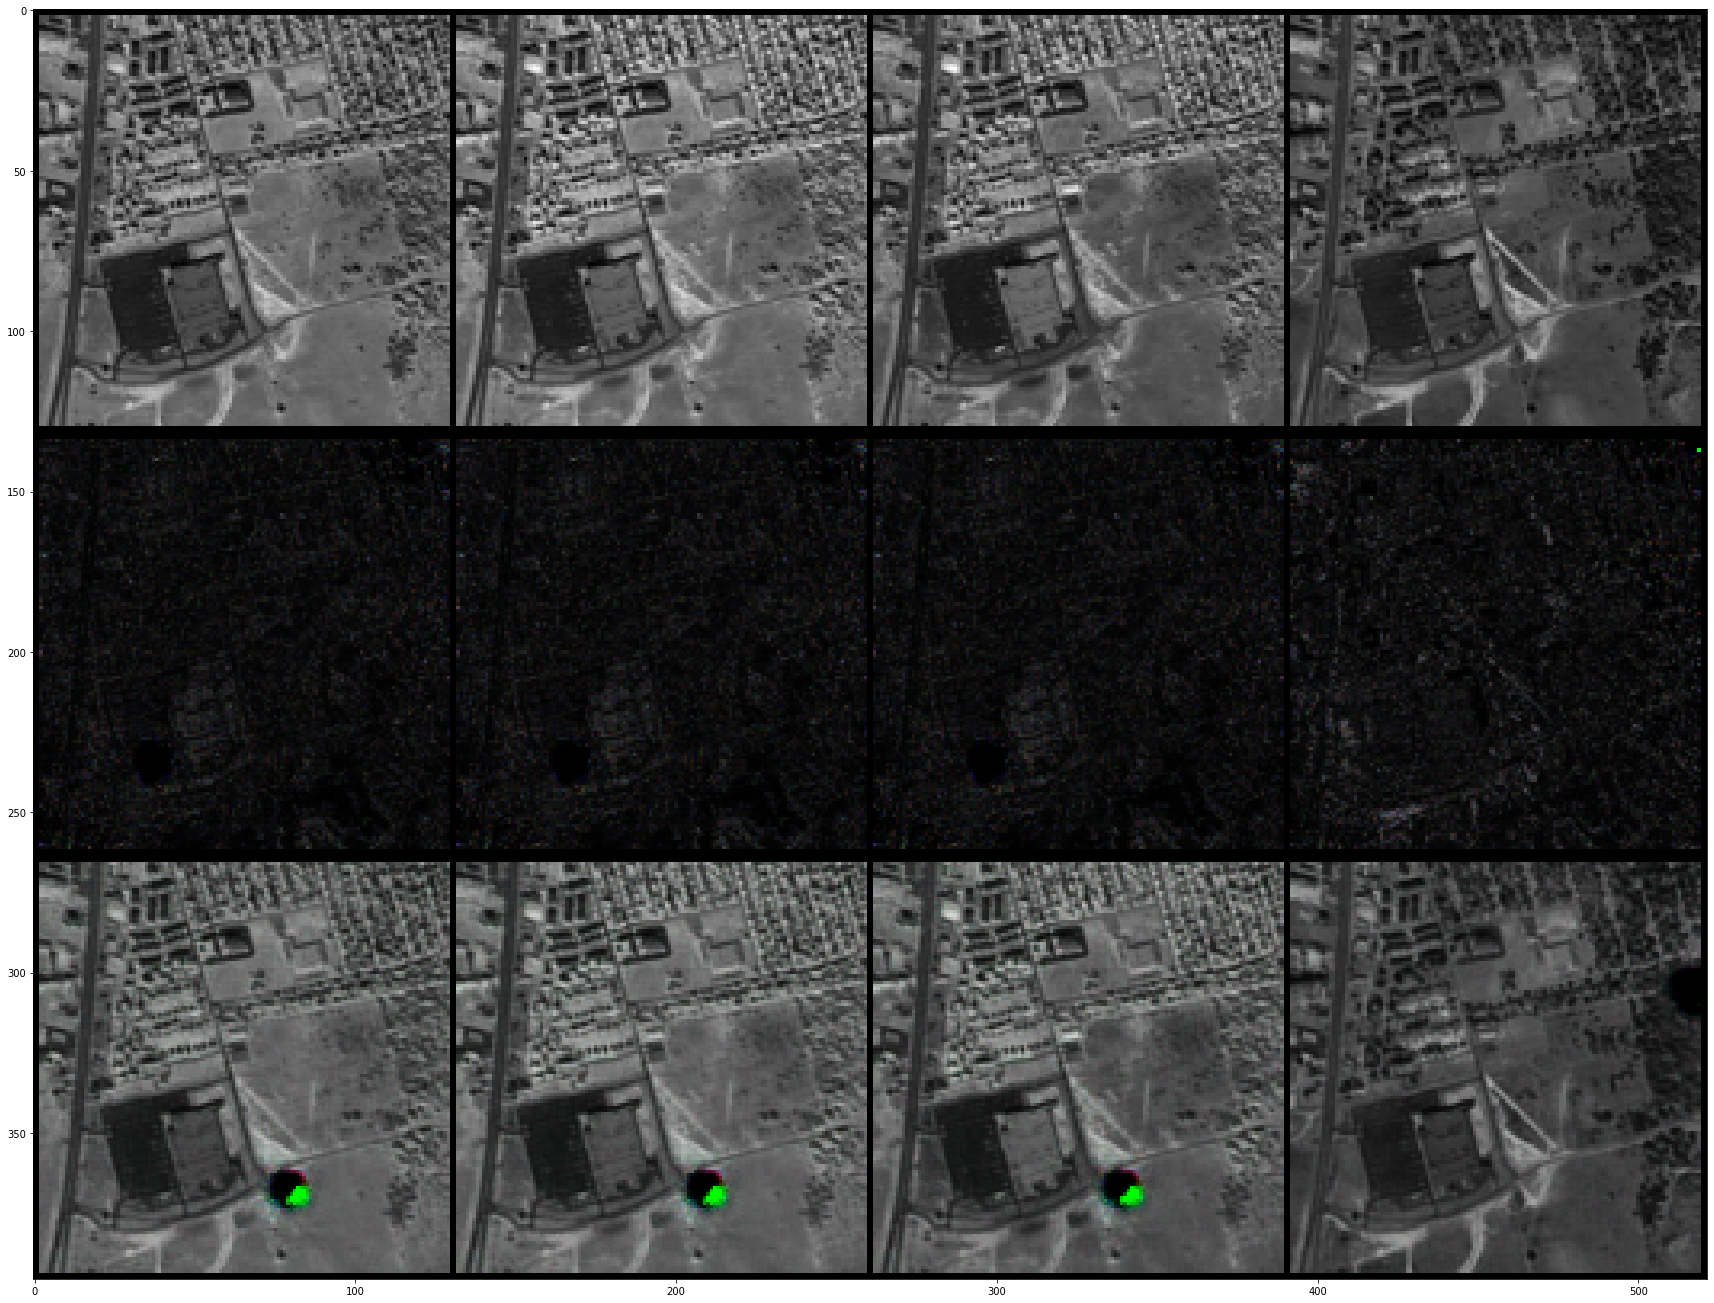

[Epoch 97/100] [Batch 21/40] [D loss: 0.045489] [G loss: 1.093870, adv: 0.598404, cycle: 0.034387, identity: 0.030320] ETA: 0:07:49.497239
[Epoch 97/100] [Batch 22/40] [D loss: 0.048312] [G loss: 1.207222, adv: 0.776103, cycle: 0.029828, identity: 0.026568] ETA: 0:05:21.190646
[Epoch 97/100] [Batch 23/40] [D loss: 0.048068] [G loss: 1.343191, adv: 0.986174, cycle: 0.024663, identity: 0.022077] ETA: 0:05:19.023706
[Epoch 97/100] [Batch 24/40] [D loss: 0.084296] [G loss: 1.421900, adv: 1.116219, cycle: 0.020922, identity: 0.019292] ETA: 0:05:13.412384
[Epoch 97/100] [Batch 25/40] [D loss: 0.100498] [G loss: 1.313997, adv: 0.881217, cycle: 0.030761, identity: 0.025034] ETA: 0:05:10.723270
[Epoch 97/100] [Batch 26/40] [D loss: 0.184611] [G loss: 1.424086, adv: 1.034061, cycle: 0.026518, identity: 0.024969] ETA: 0:05:07.125204
[Epoch 97/100] [Batch 27/40] [D loss: 0.136675] [G loss: 1.177828, adv: 0.642322, cycle: 0.040983, identity: 0.025135] ETA: 0:05:04.508379
[Epoch 97/100] [Batch 28/40

In [ ]:
train(
    Gen_BA = Gen_BA,
    Gen_AB = Gen_AB,
    Disc_A = Disc_A,
    Disc_B = Disc_B,
    train_dataloader = train_dataloader,
    n_epochs = hp.n_epochs,
    criterion_identity = criterion_identity,
    criterion_cycle = criterion_cycle,
    lambda_cyc = hp.lambda_cyc,
    criterion_GAN = criterion_GAN,
    optimizer_G = optimizer_G,
    fake_A_buffer = fake_A_buffer,
    fake_B_buffer = fake_B_buffer,
    clear_output = clear_output,
    optimizer_Disc_A = optimizer_Disc_A,
    optimizer_Disc_B = optimizer_Disc_B,
    Tensor = Tensor,
    sample_interval = hp.sample_interval,
    lambda_id = hp.lambda_id,
)